# Technical Notebook

___

### Goal: 
Divorce rates have been increasing in the United States over the past several decades. In order to understand this phenomena in a tangible way, we develop an ensemble model to predict the marital status of American individuals - as either divorced or married. The feature importances surfaced through the prediction model are informative for further social and economic research as well as public programming.

### Data:
**[IPUMS USA](https://usa.ipums.org/usa/index.shtml)** supplies microdata on the American population for social, economic, and health research, aggregated from:
- 16 federal censuses
- American Community of Surveys, 2000-present
- Puerto Rican Community Surveys, 2005-present

Information is available on households or individual persons. In this project, we use **2018 survey data on 1.8 million individuals**. 

Output data is in fixed-width format, and to map information substrings to associated variables, we use [@ameasure's function on GitHub](https://github.com/ameasure/IPUMS-helper).

### Model Selection:
We run three classification models through a voting cassifier to reduce misclassification errors. The three models utilized are:
- **Random Forest**
  - The many independent decision trees in a random forest generally achieve high classification strength, partly due to random forest's inherent resistant to noise and variance.
- **Logistic Regression**
  - Also a common classifier model, especially appropriate for large datasets such as ours.
- **Gradient Boosting**  
  - The iterative weighting of decision trees would optimize classification of hard-to-predict outcomes. As a tree-based method, it is also resistant to noisy data and overfitting.

### Contents:
1. **Understanding the Data**
2. **Feature Selection**
3. **Hyperparameter Selection**
4. **Ensemble Model Design**
5. **Model Results**
6. **Feature Analysis**

___
### 1. Understanding the Data
Here we directly read in a .csv file  - cleaned using our [protocol](https://github.com/gksidhu/development_econ/blob/master/python_files/data_cleaning.py), which is available among our python files.

In [48]:
# Import needed libraries
%run /Users/flatironschooldc3/FlatironSchoolRepo/Projects/Divorce/python_files/imports.py

# Plot graphs within notebook
%matplotlib inline

# Ignore unnecessary warnings
# warnings.filterwarnings('ignore')

In [46]:
# Read in data
df = pd.read_csv('ipums_1.csv')
df.head(2)

,MIGRATE1,VETSTAT,UHRSWORK,OCC,EMPSTAT,YRMARR,ANCESTR1,CLASSWKR,EDUC,INCTOT,...,MARST,NCHLT5,VALUEH,HHINCOME,MORTAMT1,YEAR,AGEMARR,PCT_HHINC,PCT_MTG_INC,OCC_BROAD
0,1,1,0,0,3,1992,north american,0,2,15000,...,5,0,9999999,9999999,0,2018,40,0.15,0.0,other
1,1,1,0,0,3,1993,north american,0,2,12000,...,2,0,9999999,9999999,0,2018,40,0.12,0.0,other


**Target variable = marital status, or MARST.**
Our target variable requires simplification from four classes: 
- Married with spouse present --> married
- Married with spouse absent --> married
- Widowed --> married
- Divorced --> divorced
- Separated --> divorced
    
**Indepedent variables:**
  - 16 categorical
  - 8 continuous

In [8]:
# Create binary target variable, 0 = married, 1 = divorced
df.MARST = df.MARST.map({1:0, 2:0, 5:0, 3:1, 4:1})
# Understand proportion of target variables outcomes
df.MARST.value_counts(normalize=True)

0    0.82251
1    0.17749
Name: MARST, dtype: float64

As we can see above, the divorced population is much smaller than the married population. To allow for equalized training on both target variable outcomes (married and divorced), we can oversample from the divorced population subset using SMOTE.

**Defining variables:**

In [9]:
# define X
X = df.drop(['YRMARR', 'BIRTHYR', 'YEAR', 'OCC', 'PERWT', 'STRATA', 'CLUSTER', 'MARST'], axis=1)
# define y
y = df.MARST

# define dummies, or categorical variables
dummies = ['MIGRATE1', 'VETSTAT', 'EMPSTAT', 'ANCESTR1', 'STATEFIP', 'OCC_BROAD', 'CLASSWKR', 'NCHILD', 'MARRNO', 'NCHLT5', 
           'SEX', 'DEGFIELD', 'HISPAN', 'RACE', 'EDUC', 'MORTGAGE']

___
### 2. Feature Selection

We utilize Random Forest to select the most important features for input into the final model. 

When training a tree, the Random Forest classifier ranks a feature's importance based on how much it decreases sample impurity weighted by the probability of samples reaching the node. The feature importance output from random forest is an average of the impurity of a feature across all trees in the forest. 

In [10]:
# Setup the Random Forest model
rf = RandomForestClassifier(n_estimators=25, random_state=42, verbose=3, n_jobs=-1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify = y)

# One hot encode categorical variables
X_train_enc = pd.get_dummies(data = X_train, columns = dummies, drop_first = True)

In [11]:
# Run SMOTE since divorced outcome target is only 18% of our dataset
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE_imb(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train_enc, y_train.ravel())

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 233683
Before OverSampling, counts of label '0': 1082916 

After OverSampling, counts of label '1': 1082916
After OverSampling, counts of label '0': 1082916


In [12]:
# Fit the model to the one-hot-encoded, oversampled training set   
rf.fit(X_train_res, y_train_res)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 25building tree 2 of 25building tree 3 of 25building tree 4 of 25



building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=3,
                       warm_start=False)

After fitting the model to our training set, we plot feature importance. Below, we consider all features including and ranked above 'NCHLT5' (Number of children under five years of age). 

From these features, we drop household income and total inidvidual income since percent contribution to household income is a function of both variables and has over double the importance.

We also drop other catorgories from the top list of features, as they tell us more about the diversity of individuals who are divorced rather than the features they have in common. For example, 'other' as an occupation or ancestral background is uninformative for our purposes.

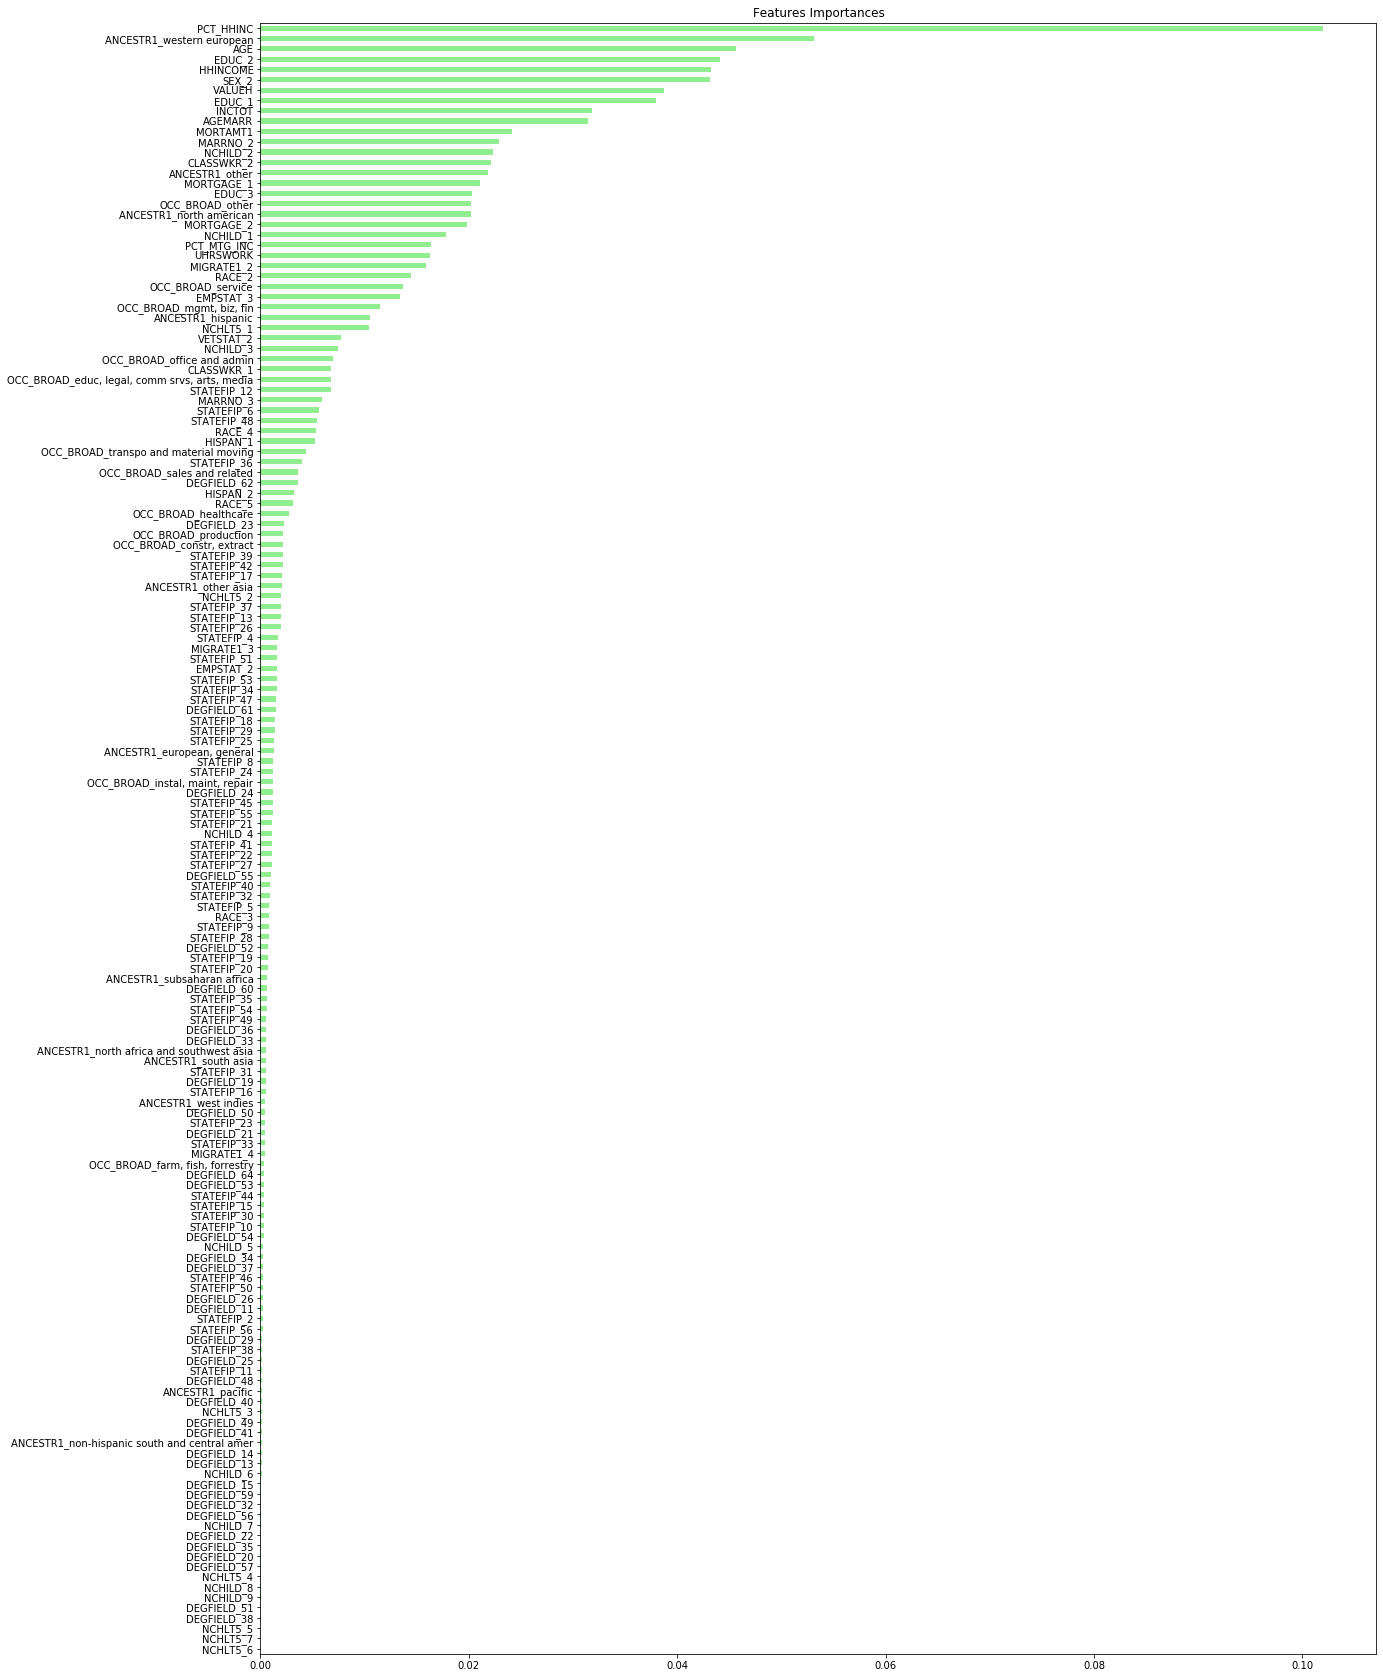

In [13]:
col_names = X_train_enc.columns.tolist()

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= col_names)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(20,30))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

### 3. Hyperparameter Selection
Based on the features of high importance above, we perform the following steps to downselect our independent variables:

1. Define dummies as categorical variables
2. Train/test split
3. One-hot encode categorical variables in train and test sets
4. Ensure same one-hot encoding in both train and test sets
5. Select only for top features in both train and test sets
6. Perform SMOTE (oversampling) on training set to adjust for disproportionate outcomes 
7. Standard scale (or assign z-scores) train and test data

These preliminary steps lay the ground for us to search for appropriate hyperparameters for models input into our final ensemble. 

Here, we use RandomizedSearchCV on logistics regression only. We do this to obtain an optimized C hyperparameter, which determines the regularization strength. We chose to search logistic regression parameter only because random forest is inherently resilient to overfitting. 

In [32]:
# %load -r 1-49 /Users/flatironschooldc3/FlatironSchoolRepo/Projects/Divorce/notebooks/utils.py
dummies = ['MIGRATE1', 'VETSTAT', 'EMPSTAT', 'ANCESTR1', 'STATEFIP', 'OCC_BROAD', 'CLASSWKR', 'NCHILD', 'MARRNO', 'NCHLT5',
           'SEX', 'DEGFIELD', 'HISPAN', 'RACE', 'EDUC', 'MORTGAGE']

# Create training and test sets using smaller split to RandomSearch hyperparameters for LogReg and XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9,random_state=42, stratify = y)

# One hot encode categorical variables
X_train_enc = pd.get_dummies(data = X_train, columns = dummies, drop_first = True)
X_test_enc = pd.get_dummies(data = X_test, columns = dummies, drop_first = True)

# Ensure same variables in train and test datasets
# Get missing columns in the training test
missing_cols = set(X_train_enc.columns ) - set(X_test_enc.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test_enc[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test_enc = X_test_enc[X_train_enc.columns]

# Keep more important features as displayed in graph above
X_train_feat = X_train_enc[['PCT_HHINC', 'ANCESTR1_western european', 'AGE', 'EDUC_2', 'SEX_2', 'VALUEH', 'EDUC_1',
                           'AGEMARR', 'MORTAMT1', 'MARRNO_2', 'NCHILD_2', 'CLASSWKR_2', 'MORTGAGE_1', 'EDUC_3',
                           'ANCESTR1_north american', 'MORTGAGE_2', 'NCHILD_1', 'PCT_MTG_INC', 'UHRSWORK', 'MIGRATE1_2',
                           'RACE_2', 'OCC_BROAD_service', 'EMPSTAT_3', 'OCC_BROAD_mgmt, biz, fin', 'ANCESTR1_hispanic',
                           'NCHLT5_1']]

X_test_feat = X_test_enc[['PCT_HHINC', 'ANCESTR1_western european', 'AGE', 'EDUC_2', 'SEX_2', 'VALUEH', 'EDUC_1',
                           'AGEMARR', 'MORTAMT1', 'MARRNO_2', 'NCHILD_2', 'CLASSWKR_2', 'MORTGAGE_1', 'EDUC_3',
                           'ANCESTR1_north american', 'MORTGAGE_2', 'NCHILD_1', 'PCT_MTG_INC', 'UHRSWORK', 'MIGRATE1_2',
                           'RACE_2', 'OCC_BROAD_service', 'EMPSTAT_3', 'OCC_BROAD_mgmt, biz, fin', 'ANCESTR1_hispanic',
                           'NCHLT5_1']]

# Run SMOTE since divorced outcome target is only 18% of our dataset
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE_imb(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train_feat, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

# Normalization required for logistic regression
ss = StandardScaler(with_mean=True)
X_train_sm_ss = ss.fit_transform(X_train_sm)
X_test_ss = ss.transform(X_test_feat)

Before OverSampling, counts of label '1': 33383
Before OverSampling, counts of label '0': 154702 

After OverSampling, the shape of train_X: (2165832, 158)
After OverSampling, the shape of train_y: (2165832,) 

After OverSampling, counts of label '1': 1082916
After OverSampling, counts of label '0': 1082916


In [33]:
# Specify logistic regression parameters and distributions to sample from
param_dist = {'C': np.linspace(.001, 100, 20)}

logreg = LogisticRegression(solver = 'liblinear')

rs = RandomizedSearchCV(logreg, param_dist, verbose = 3, n_jobs = -1, cv = 3)
rs.fit(X_train_sm_ss, y_train_sm)

# Print optimized hyper parameter values
rs.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.5s finished


LogisticRegression(C=42.10584210526315, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
lr = LogisticRegression(C=52.6, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

lr.fit(X_train_sm_ss, y_train_sm.ravel())

LogisticRegression(C=52.6, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
# lr output based on training data
conf_matrix = pd.DataFrame(confusion_matrix(y_train_sm, lr.predict(X_train_sm_ss)),
                           index = ['actual married', 'actual divorced'], 
                           columns = ['predicted married', 'predicted divorced'])
conf_matrix

,predicted married,predicted divorced
actual married,108127,46575
actual divorced,49856,104846


In [37]:
print(classification_report(y_train_sm, lr.predict(X_train_sm_ss))) # report on training data

              precision    recall  f1-score   support

           0       0.68      0.70      0.69    154702
           1       0.69      0.68      0.68    154702

    accuracy                           0.69    309404
   macro avg       0.69      0.69      0.69    309404
weighted avg       0.69      0.69      0.69    309404



### 4. Ensemble Model Design

To begin assembling our final model, we first instantiate each model used and then evaluate the individual models before using a voting classifier to obtain a final aggregate model score.

In [38]:
'''Define the ensemble'''
# Set seed
SEED=42
# Instantiate lr
lr = LogisticRegression(C=52.6, verbose=3, random_state=SEED, solver='liblinear')
# Instantiate knn
rf = RandomForestClassifier(n_estimators=100, random_state=SEED, verbose=3, n_jobs=-1)
# Instantiate gb
gb = GradientBoostingClassifier(max_depth=3, 
            n_estimators=100, verbose=3,
            random_state=SEED)


# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('Random Forest', rf), ('Gradient Boost', gb)]

In [49]:
'''Evaluate individual classifiers'''
# Iterate over the list of classifiers
for clf_name, clf in classifiers:    
    # Fit clf to the training set
    clf.fit(X_train_sm_ss, y_train_sm)    
    # Predict y_pred
    y_pred = clf.predict(X_test_ss)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

[LibLinear]Logistic Regression : 0.694
building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100





[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100building tree 24 of 100

building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.5s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   31.5s finished


Random Forest : 0.850
      Iter       Train Loss   Remaining Time 
         1           1.3226            2.14m
         2           1.2702            1.89m
         3           1.2263            1.78m
         4           1.1898            1.73m
         5           1.1495            1.69m
         6           1.1233            1.66m
         7           1.0981            1.65m
         8           1.0806            1.61m
         9           1.0637            1.56m
        10           1.0462            1.53m
        11           1.0323            1.49m
        12           1.0127            1.47m
        13           0.9923            1.45m
        14           0.9644            1.43m
        15           0.9536            1.40m
        16           0.9420            1.38m
        17           0.9230            1.37m
        18           0.8972            1.35m
        19           0.8820            1.33m
        20           0.8721            1.31m
        21           0.8519     

In [50]:
'''Improve performance with voting classifier'''
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier
# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=-1)     
# Fit vc to the training set
vc.fit(X_train_sm_ss, y_train_sm)   
# Evaluate the test set predictions
y_pred = vc.predict(X_test_ss)
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   31.1s finished


Voting Classifier: 0.846


### 5. Results

Precision - We chose to focus on precision because of the imbalance in our test set. While we achieved close to 60% correct Divorce predictions out of all observations we predicted as divorced, there are areas for futher exploration and improvement. Our accuracy was high (85%) as a result of the test data imbalance. Still, the ROC curve is informative because it tells us the threshold at which our model has the best performance.  

While accuracy is not our metric of focus, it is important to understand how the accuracy of each model affects the overall ensemble score. In this case, we used two tree-based models that may have had significant overlap in the tpes of errors that each reduced. As such, the reduction in error of the combined set of models was not significantly affected through the ensemble approach. At the same time, the final score is very close to the highest individual model score, reflecting that random forest was the strongest contributor to the overall ensemble model. If we use an additional model that is significantly different from other models employed, such as support vector machines or SVM, we have been able to reduce more error through the ensemble approach.

#### Further Exploration

The significant reduction in precision between our test and train set leads us to infer that there may be some overfitting. Going forward, we can adjust the depth of the random forest decision trees and more broadly, gridsearched the random forest model.

In [51]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred),
                           index = ['actual married', 'actual divorced'], 
                           columns = ['predicted married', 'predicted divorced'])
conf_matrix

,predicted married,predicted divorced
actual married,1295404,96917
actual divorced,164221,136229


In [52]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91   1392321
           1       0.58      0.45      0.51    300450

    accuracy                           0.85   1692771
   macro avg       0.74      0.69      0.71   1692771
weighted avg       0.83      0.85      0.84   1692771



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   26.9s finished


Text(0.5, 1.0, 'ROC Curve')

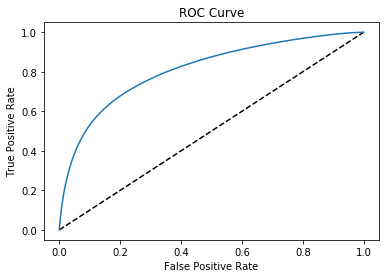

In [53]:
# ROC curve
from sklearn.metrics import roc_curve
# Compute predicted probabilities: y_pred_prob
y_pred_prob = vc.predict_proba(X_test_ss)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [54]:
# Import modules
from sklearn.metrics import roc_auc_score

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8095822416685617


### 6. Feature Analysis

In [ ]:
rf.fit(X_train_sm_ss, y_train_sm)

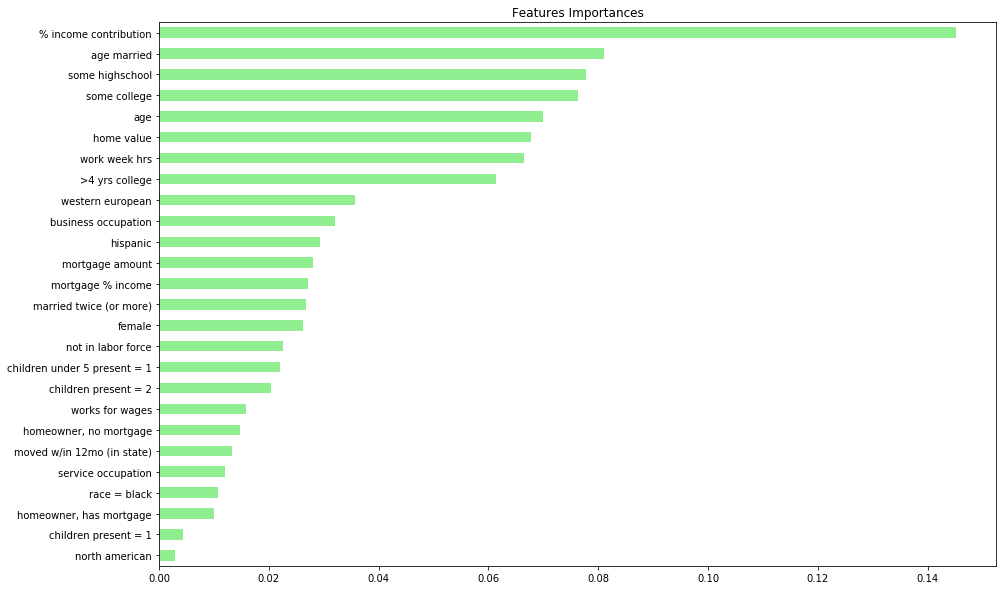

In [62]:
labels = ['% income contribution', 'age', 'age married', 'home value', 'some highschool', 'work week hrs', 'some college','>4 yrs college',
         'children present = 2', 'mortgage % income', 'western european', 'mortgage amount', 'children present = 1', 'female', 'hispanic','north american',
         'business occupation', 'children under 5 present = 1', 'married twice (or more)', 'not in labor force', 'works for wages',
         'service occupation', 'moved w/in 12mo (in state)', 'race = black', 'homeowner, no mortgage', 'homeowner, has mortgage']

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= labels)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(15,10))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [56]:
# We draw out the relative magnitudes and directions of the coefficients

coef = list(zip(X_test_feat.columns, lr.coef_[0]))
sorted(coef, key=lambda x: np.abs(x[1]), reverse=True)

[('MORTGAGE_1', -1.2613525936932801),
 ('MORTGAGE_2', -1.2187067900246147),
 ('VALUEH', -0.8603225561524073),
 ('PCT_HHINC', 0.7932821008770087),
 ('NCHLT5_1', -0.3257666080965728),
 ('AGE', -0.24731870250058485),
 ('NCHILD_2', -0.22077867406403498),
 ('MORTAMT1', -0.1895206907592076),
 ('SEX_2', 0.17811784957956084),
 ('MIGRATE1_2', 0.16483707575771483),
 ('UHRSWORK', -0.15519412388405499),
 ('RACE_2', 0.14580072278475814),
 ('EDUC_3', -0.12277183215097241),
 ('MARRNO_2', 0.09694779443451378),
 ('EDUC_1', 0.07876031487841866),
 ('AGEMARR', -0.07579999840696805),
 ('OCC_BROAD_service', 0.06759446372588214),
 ('OCC_BROAD_mgmt, biz, fin', -0.05271384146838775),
 ('CLASSWKR_2', 0.04699572512544782),
 ('ANCESTR1_north american', 0.03439851731929192),
 ('EDUC_2', -0.023451910547821433),
 ('EMPSTAT_3', -0.021956296326281616),
 ('ANCESTR1_hispanic', 0.01556951053038669),
 ('ANCESTR1_western european', -0.0039212287358792565),
 ('NCHILD_1', -0.0027908560499117774),
 ('PCT_MTG_INC', 0.001469106

The three most important features were:
1. % inome contribution - this reflects the proportion of total houshold income to which the individual contributes. The was the highest positive relationship we observed. Moreover, as % contribution increases, our model estimates the likelihood of Divorce increases.
2. age married - age married reflects the age at which the individual was married. While this what the second most important feature according to random forest, the logistic regression model assigns low negative beta.
3. some high school - the indicates that the individual has completed at least the ninth grade, but lacks a college education. This is a categorical variable and negative with respect to the base case.

**Conclusion**
There are many implications of these observed relationships. Most apparent is that people who get married younnger and who have relatively lower home value, tend to be at higher risk for divorce. This is in line with 

 Furthermore, our recommendations include the following:
1. We recommend tareted community services that support these demographics incorperate marriage and divorce counseling services to this group. 
2. Moreover, the services can focus on key issues that will likely be the focus in divorce settlements.
